In [1]:
import itertools
import numpy as np
from nltk.corpus import brown
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd
import matplotlib.pyplot as plt

## Train LSA model based on very small corpus

In [3]:
CORPUS_SIZE = 30000
brown_sample = [" ".join([w.lower() for w in itertools.chain(*x) if w.isalpha()])
                for x in brown.paras()[:CORPUS_SIZE]]
print(len(brown_sample))
brown_sample[0]

15667


'the fulton county grand jury said friday an investigation of recent primary election produced no evidence that any irregularities took place'

In [4]:
WORDS = ["football", "baseball", "ball", "players", "coach"]

### Examine word representations prior to SVD

In [5]:
MIN_WORD_DOC_FREQ = 10
vectorizer = CountVectorizer(
    stop_words="english", 
    min_df=MIN_WORD_DOC_FREQ
)

term_doc_matrix = vectorizer.fit_transform(brown_sample)

In [6]:
term_doc_matrix.shape

(15667, 7289)

In [7]:
list(vectorizer.vocabulary_.items())[:10]

[('fulton', 2773),
 ('county', 1515),
 ('grand', 2919),
 ('jury', 3582),
 ('said', 5666),
 ('friday', 2751),
 ('investigation', 3478),
 ('recent', 5302),
 ('primary', 4997),
 ('election', 2160)]

#### Sparsity of vectors for 5 selected words

In [8]:
col_indices = [vectorizer.vocabulary_[w] for w in WORDS]
for i, w in enumerate(WORDS):
    doc_count = term_doc_matrix[:,col_indices[i]].todense().astype(bool).sum()
    print(f"Vector for '{w:8s}' has {doc_count} nonzero elements ({100*doc_count/1000}%)%")

Vector for 'football' has 33 nonzero elements (3.3%)%
Vector for 'baseball' has 48 nonzero elements (4.8%)%
Vector for 'ball    ' has 82 nonzero elements (8.2%)%
Vector for 'players ' has 29 nonzero elements (2.9%)%
Vector for 'coach   ' has 20 nonzero elements (2.0%)%


#### Last 100 rows (documents) for 5 selected columns (words) of term-document matrix

In [9]:
#Matrix(term_doc_matrix[900:,col_indices].todense())
print(WORDS)
term_doc_matrix[:10,col_indices].todense()

['football', 'baseball', 'ball', 'players', 'coach']


matrix([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]])

### Examine reduced-dimensionality representations

#### Apply SVD

See references for `TruncatedSVD`:

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

In [10]:
svd = TruncatedSVD(n_components=30)
approx_term_document_matrix = svd.fit_transform(term_doc_matrix)
svd_w = svd.components_
print(svd_w.shape)

(30, 7289)


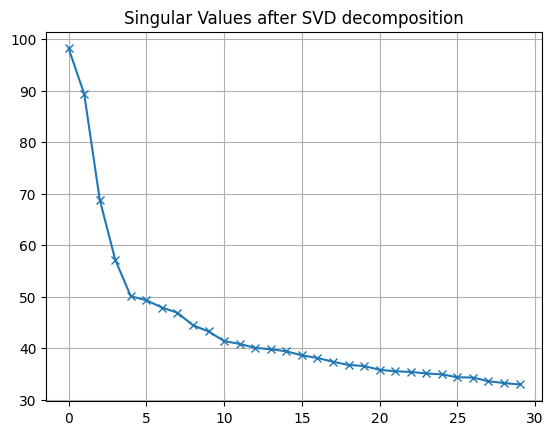

In [11]:
pd.Series(svd.singular_values_).plot(marker="x",grid=True)
_=plt.title("Singular Values after SVD decomposition") 

#### Sparsity of vectors for 5 selected vectors

In [12]:
print(f"% zero-valued cells: {(svd_w[:,col_indices]==0.0).mean():.2f}")

% zero-valued cells: 0.00


In [13]:
for i, w in enumerate(WORDS):
    doc_count = svd_w[:,col_indices[i]].astype(bool).sum()
    print(f"Vector for '{w:8s}' has {doc_count} nonzero elements ({100*doc_count/30:0.1f}%)")

Vector for 'football' has 30 nonzero elements (100.0%)
Vector for 'baseball' has 30 nonzero elements (100.0%)
Vector for 'ball    ' has 30 nonzero elements (100.0%)
Vector for 'players ' has 30 nonzero elements (100.0%)
Vector for 'coach   ' has 30 nonzero elements (100.0%)


#### Vectors for 5 selected words from LSA

In [14]:
#Matrix(svd_w[:,col_indices]).evalf(2)

svd_w[:,col_indices].round(3)  # rounding for display

array([[ 0.002,  0.003,  0.012,  0.002,  0.001],
       [-0.001, -0.003, -0.01 , -0.001, -0.001],
       [-0.001, -0.002, -0.014, -0.001, -0.001],
       [ 0.   ,  0.   ,  0.022,  0.001,  0.001],
       [ 0.001, -0.002, -0.008,  0.004,  0.   ],
       [ 0.   , -0.002, -0.012,  0.006, -0.   ],
       [ 0.001,  0.002,  0.012,  0.   ,  0.001],
       [-0.001, -0.001,  0.005,  0.005,  0.001],
       [-0.   ,  0.001,  0.011,  0.   , -0.   ],
       [-0.001, -0.   , -0.005,  0.002, -0.001],
       [-0.003, -0.003,  0.004, -0.001, -0.001],
       [-0.001, -0.003, -0.008, -0.001, -0.   ],
       [-0.003, -0.007,  0.008, -0.001, -0.   ],
       [ 0.   , -0.001, -0.008,  0.001,  0.001],
       [ 0.002,  0.007,  0.01 , -0.   ,  0.001],
       [-0.001, -0.   , -0.014,  0.001, -0.   ],
       [-0.001, -0.002, -0.017,  0.001, -0.   ],
       [-0.004, -0.003,  0.011,  0.001, -0.   ],
       [-0.003, -0.004, -0.014, -0.001, -0.   ],
       [ 0.002,  0.002, -0.017, -0.002, -0.   ],
       [-0.   ,  0. 

### Look at word similarities

In [15]:
def term_doc_similarity(w1, w2):
    col1 = vectorizer.vocabulary_[w1]
    col2 = vectorizer.vocabulary_[w2]
    vec1 = np.asarray(term_doc_matrix[:,col1].todense()).flatten()
    vec2 = np.asarray(term_doc_matrix[:,col2].todense()).flatten()
    return np.dot(vec1, vec2) / np.sqrt(np.dot(vec1, vec1) * np.dot(vec2, vec2))

In [16]:
term_doc_similarity("players", "ball")

0.0643782753280756

In [17]:
term_doc_similarity("football", "baseball")

0.08680241605735182

In [18]:
term_doc_similarity("players", "coach")

0.19695964928958382

In [19]:
term_doc_similarity("football", "ball")

0.03209703693831847

In [20]:
def lsa_similarity(w1, w2):
    col1 = vectorizer.vocabulary_[w1]
    col2 = vectorizer.vocabulary_[w2]
    vec1 = svd_w[:,col1]
    vec2 = svd_w[:,col2]
    return np.dot(vec1, vec2) / np.sqrt(np.dot(vec1, vec1) * np.dot(vec2, vec2))

In [21]:
lsa_similarity("players", "ball")

0.0500812669112495

In [22]:
lsa_similarity("football", "baseball")

0.5832219024264103

In [23]:
lsa_similarity("players", "coach")

0.30612631754481245

In [24]:
lsa_similarity("players", "jury")

0.008184650828937877

In [25]:
lsa_similarity("football", "ball")

0.0016402672652023392

## Demo - visualizing word vectors?

SVD -> "Dimensionality Reduction"

In [27]:
# represent words with dominant 2 dimensions -> loss of information

svd_w[:2,:].T
df_svd = pd.DataFrame(svd_w[:2,:].T, columns=("dim1","dim2"), index=vectorizer.vocabulary_)
df_svd.loc[WORDS]

,dim1,dim2
football,0.000906,-0.000729
baseball,0.000460,-0.000340
ball,0.006938,0.002024
players,0.003437,-0.002570
coach,0.003539,-0.002852


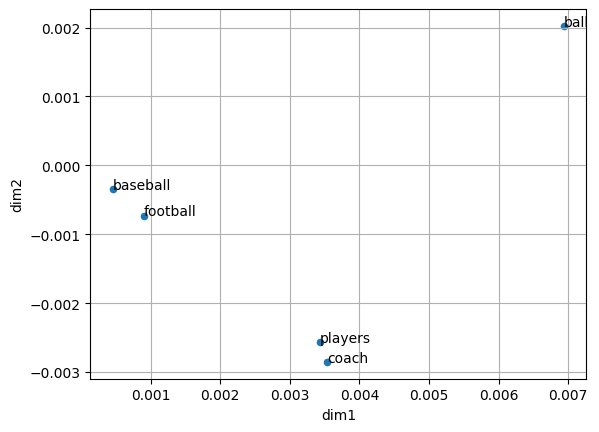

In [28]:
# applying matplotlib to label points:

ax = df_svd.loc[WORDS].plot.scatter(x="dim1",y="dim2",grid=True)
for i, w in enumerate(WORDS):
    pt = (df_svd.loc[w].dim1, df_svd.loc[w].dim2)
    ax.annotate(w, pt)

# Does this reflect our human understanding of these words? 